In [2]:
!pip install keymorph
import numpy as np
import nibabel as nib
import torchio as tio
from keymorph.viz_tools import imshow_img_and_points_3d

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.8 MB/s eta 0:00:00
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=f20911f79fbee61925bb44e4cd78367797c5e04586e9b95f6e7e158b42b28e7e
  Stored in directory: /home/alw4013/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built littleutils


Run the registration command on example data:

In [3]:
!python scripts/register.py \
    --num_keypoints 256 \
    --num_levels_for_unet 4 \
    --weights_dir /midtier/sablab/scratch/alw4013/keymorph/weights/keymorph_weights_256x256x256 \
    --moving ./example_data/img_m/IXI_000001_0000.nii.gz \
    --fixed ./example_data/img_m/IXI_000002_0000.nii.gz \
    --moving_seg ./example_data/seg_m/IXI_000001_0000.nii.gz \
    --fixed_seg ./example_data/seg_m/IXI_000002_0000.nii.gz \
    --list_of_aligns rigid affine tps_1 \
    --list_of_metrics mse harddice \
    --save_eval_to_disk \
    --visualize

Number of GPUs: 0

Model Summary
---------------------------------------------------------------
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv1.conv.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.0.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.0.basic_module.SingleConv2.conv.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv1.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv1.conv.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.weight
backbone.module.encoders.1.basic_module.SingleConv2.groupnorm.bias
backbone.module.encoders.1.basic_module.SingleConv2.conv.weight
backbone.module.encoders.2.basic_module.SingleConv1.groupnorm.weight
backbone.module.encoders.2.basic_m

Load the images and points which the above command generates:

In [14]:
moving_path = './example_data/img_m/IXI_000001_0000.nii.gz'
fixed_path = './example_data/img_m/IXI_000002_0000.nii.gz'
aligned_path = './register_output/eval/0_0_fixed_moving/img_a_0-fixed_0-moving-rot0-tps_1.npy'

points_m_path = 'register_output/eval/0_0_fixed_moving/points_m_0-moving-rot0.npy'
points_f_path = 'register_output/eval/0_0_fixed_moving/points_f_0-fixed.npy'
points_a_path = 'register_output/eval/0_0_fixed_moving/points_a_0-fixed_0-moving-rot0-tps_1.npy'
'register_output/eval/0_0_fixed_moving/points_weights_0-fixed_0-moving-rot0-rigid.npy'
points_weights_path = 'register_output/eval/0_0_fixed_moving/points_weights_0-fixed_0-moving-rot0-tps_1.npy'

moving = nib.load(moving_path).get_fdata()
fixed = nib.load(fixed_path).get_fdata()
aligned = np.load(aligned_path)[0]

points_m = np.load(points_m_path)
points_f = np.load(points_f_path)
points_a = np.load(points_a_path)
points_af = np.stack((points_a, points_f))
points_weights = np.load(points_weights_path)
print(moving.shape, fixed.shape, aligned.shape)
print(points_m.shape, points_f.shape, points_a.shape, points_weights.shape)

(256, 256, 150) (256, 256, 150) (256, 256, 256)
(256, 3) (256, 3) (256, 3) (256,)


Visualize the results. Note that the script always outputs registration results which are 1mm isotropic and cropped/padded to size 256x256x256. For the overlaying of keypoints in the visualizations to make sense, we will manually apply these transformations to the images:

Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates
Converting points from [-1, 1] to image coordinates


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

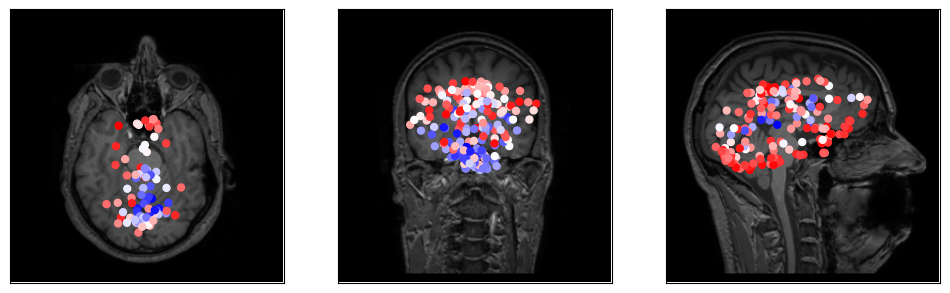

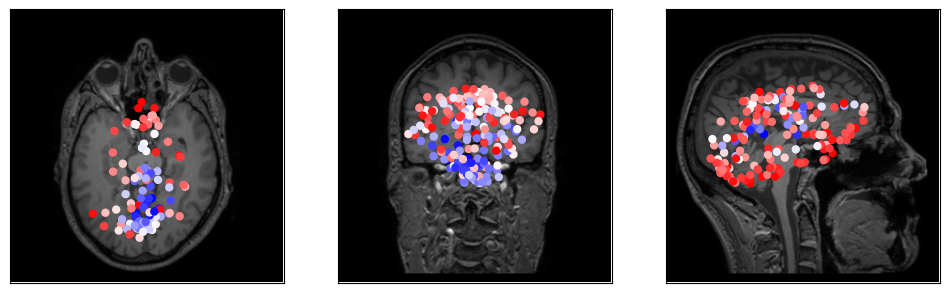

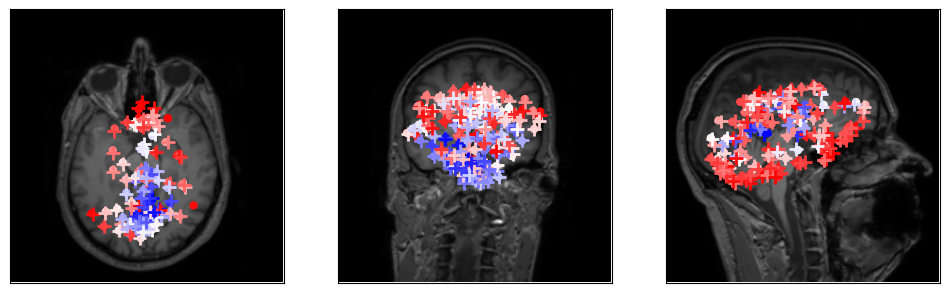

In [15]:
transform = tio.Compose(
            [
                tio.ToCanonical(),
                tio.Resample(1),
                tio.Resample("img"),
                tio.CropOrPad((256, 256, 256), padding_mode=0, include=("img",)),
                tio.CropOrPad((256, 256, 256), padding_mode=0, include=("seg",)),
            ],
            include=("img", "seg"),
        )
moving_subject = tio.Subject(img=tio.ScalarImage(moving_path))
fixed_subject = tio.Subject(img=tio.ScalarImage(fixed_path))

moving = transform(moving_subject)['img'].data[0]
fixed = transform(fixed_subject)['img'].data[0]

imshow_img_and_points_3d(moving, 
                         all_points=points_m, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(fixed, 
                         all_points=points_f, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)
imshow_img_and_points_3d(aligned, 
                         all_points=points_af, 
                        #  all_weights=points_weights, 
                         rotate_90_deg=1)